

```
# This is formatted as code
```

# Homework: Autoencoding MNIST and Celebrity Faces


> **Due Date: March 5th, 2025 @ 1:00pm**
>
> Please turn in this completed notebook via Google classroom. Email clay.smyth@ucsf.edu if you run into any issues.

**Collaboration policy and more**

You're welcome (and highly encouraged) to work with and discuss this homework assignment with others in the class, and feel free to use any resources (textbooks, online notebooks, etc). The only requirement is that the final notebook that you turn in must be your own written work (no copy and pasting, please).

**Overview**

In class, we cover how Hinton and Salakhutdinov's 2006 Science Paper, ["Reducing the Dimensionality of Data with Neural Networks"](https://www.science.org/doi/10.1126/science.1127647) was one of the first demonstrations of unsupervised pretraining for use in training deep neural networks. In this homework, we'll implement autoencoders in the context of MNIST. Additionally, as an optional assignment, a similar architecture can be used for a subset of CelebA dataset of celebrity faces.


## Before you get started

**1) Background reading**

Please Read Hinton and Salakhutdinov's 2006 seminal work on deep autoencoders (https://www.science.org/doi/10.1126/science.1127647), as this notebook aims to recreate this important work. A few questions to think about as you read that will help you in this assignment:
  - What architecture do they use for their deep autoencoders?
  - Why were deep neural networks so much harder to train in 2006?

**2) How to run this notebook**

This Jupyter Notebook can be used in two ways:
* *Option 1: Download the notebook*

  We've included all the imports necessary for this homework. Please make sure you're running Python 3 with PyTorch (and Torchvision) installed and ready to go, along with NumPy and Matplotlib. Although you might find that these models train a bit faster on GPU, this homework assignment should be doable on most modern laptops. If you're having trouble please let us know ASAP.

* *Option 2: Run it online on Google Colaboratory*

  - Colab gives access to a GPU, so it could be useful in case you don't have CUDA installed on your computer (**Note: you can use this as an opportunity to get started on GPU training, but we recommend you develop your model and make sure everything works on CPU first**)
  - Make a copy of this notebook in your Google Drive folder: "File" -> "Save a copy in Drive..."
  - By default, Colab does not make GPUs available, but you can easily access them by selecting GPU in "Runtime" -> "Change runtime type..."
  - Remember that Colab runs in a temporary virtual machine, so all the data created while running the notebook will be lost at the end of the session, or when the runtime disconnects due to inactivity. To preserve data between sessions, there are a couple of options:
    * you can link Colab to your personal Google Drive by mounting it on your runtime, see first cell below.
    * you can download/upload files from the Files tab on the right sidebar.

**3) How to complete this assignment**

  - Fill out the relevant code blocks as indicated
  - Answer questions by writing them directly in the text block. Please keep your written answers concise, most are meant to be answered in a sentence or two.
  - Make figures showing your results and add comments with your observations.

**4) Optional exercise: CelebA Data**

Whereas MNIST is a toy dataset built into PyTorch, we can also examine a more complex feature space using a subset of 90,000 celebrity portraits from CelebA (see [Liu et al. (2014), "Deep Learning Face Attributes in the Wild"](https://arxiv.org/abs/1411.7766)). This is an optional part of the homework, but is a nice way to see how autoencoders perform on other types of visual data. There will be a .zip file of the relevant celebrity faces dataset on the Google Classroom link.

***Let's start!***

---

## Train an autoencoder on MNIST

The following command can be used to mount your personal Google Drive folder on the temporary virtual machine, so you can recover data between sessions (follow the instructions, you'll need an authorization code). Additional info [here](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA).


In [102]:
# # Skip this cell if running locally
# from google.colab import drive
# drive.mount('/content/gdrive')

In [103]:
# Import all the necessary libraries
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

from IPython.display import Image, display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

from tqdm.autonotebook import tqdm 


You shouldn't need CUDA for this assignment, but if you want a head start, or if you just want to see the difference between using a CPU versus a GPU, set `use_cuda = True` below.
You can check if CUDA is available on your computer with: `torch.cuda.is_available()`

If you are working on Colab, make sure to activate the GPU ("Runtime" -> "Change runtime type...").

In [104]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

In [105]:
torch.manual_seed(7);

> **Question 0.1) Why is it important to set the seed for the random number generator?**

*Setting a seed ensures reproducibility in your code. If you do not set a seed, you will get different results everytime you run your model. Therefore, when you change hyperparameters or split your data, it will change your output everytime you run your model.*



### 1. MNIST Dataset

As noted in class, MNIST has been widely used to benchmark new deep learning architectures and is already built into PyTorch. We provide this data as a starting point, again noting that the mean and std of the training set are calculated to be 0.1307 and 0.3081, respectively.

In [106]:
preprocessing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    './bmi219_downloads', train=True, download=True,
    transform=preprocessing)

test_dataset = datasets.MNIST(
    './bmi219_downloads', train=False, download=True,
    transform=preprocessing)

In [107]:
# assignment code 
print(train_dataset[123][0].size())

# my code
print(train_dataset)
print(test_dataset)

type(train_dataset[0][0])

torch.Size([1, 28, 28])
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./bmi219_downloads
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./bmi219_downloads
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


torch.Tensor

> **Q1.1) How many examples do the training set and test set have?**

Train and test set has 60000 and 10000 samples respectively 

> **Q1.2) What's the format of each input example? Can we directly put these into a fully-connected layer?**

Each input example is a tensor object which can be an input example into a fully-connected layer once flattened.

> **Q1.3) Why do we normalize the input data for neural networks?**

Data should be normalized so that large or small values do not skew the neural network's weights, making the model harder to optimize.

> **Q1.4) In this scenario, MNIST is already split into a training set and a test set. What is the purpose of dataset splitting (and specifically, the purpose of a test set)? For modern deep learning, a three-way split into training, validation, and test sets is usually preferred, why?**

A common problem with deep learning models is that it can easily overfit. A test set would be an untouched dataset used to test the generalizability of the model. In modern deep learning, a validation set is added to evaluate the model every epoch, allowing for hyperparameter tuning.

### 2. Using DataLoaders for MNIST

Set up the DataLoader objects below. Although the arguments are prepopulated, you may need to change the batch sizes or other arguments during training.

In [108]:
BATCH_SIZE = 32  # <-- Please change this as necessary
NUM_WORKERS = 1  # <-- Use more workers for more CPU threads

In [109]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS)

In [110]:
one_batch=next(iter(train_loader))
one_batch[0].size()

torch.Size([32, 1, 28, 28])

> **Q2.1) It's recommended to shuffle the training data over each epoch, but this isn't typically the case for the test set, why?**

The test set is the final dataset you test your model on and in order for consistent comparison, you want to keep the test set unshuffled. 

> **Q2.2) What seems to be a good batch size for training? What happens if you train with a batch size of 1? What about a batch size equal to the total training set?**

Good batch sizes are often in powers of two because physical processors of GPU or CPU are also in powers of two. If I train a model with a batch size of one, my gradients will update with every example, making my model run slow and inefficient. If I train a model with a batch size equal to my total training set, my gradient will update once, making my model run slow and poorly generalize. 

> **Q2.3) The PyTorch DataLoader object is an iterator that generates batches as it's called. Try to pull a few images from the training set to see what these images look like. Does the DataLoader return only the images? What about the labels?**

The dataloader returns a tuple containing the image and the label.

### 3. Define your neural network architecture

With your data and dataloaders appropriately set, you're ready to define a network architecture. In this homework, we'll ask you to evaluate two different architectures.

For the first (we'll call it `HNet` in this homework), please implement Hinton's 2006 architecture of 7-hidden layers:

```[784 x 1000 x 500 x 250 x 2 x 250 x 500 x 1000 x 784]. ```

For the second, implement your own autoencoder architecture, `MyNet`, again using a bottleneck dimension of 2. As a note, the larger your model, the longer it will take to train. Can you achieve similar performance to the model above using a more condensed model?

**Tips:**
* Try different activation functions (Tanh, Sigmoid, ReLU, etc)
* A sequence of layers can be defined more easily using `nn.Sequential`, see [docs](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)
* Split your network into an `.encoder()` and a `.decoder()`, that will be called sequentially in `.forward()`. This will be useful later on when we'll ask to visualize the low-dimensional embeddings ("latent space") produced by the encoder.

In [129]:
class HNet(nn.Module):
    def __init__(self):
        super().__init__()
        ### Implement a version of Hinton's 2006 Autoencoder,
        ### using a bottleneck latent dimension of 2
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 1000),
            nn.Sigmoid(),
            nn.Linear(1000, 500),
            nn.Sigmoid(),
            nn.Linear(500, 250),
            nn.Sigmoid(),
            nn.Linear(250, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 250),
            nn.Sigmoid(),
            nn.Linear(250, 500),
            nn.Sigmoid(),
            nn.Linear(500, 1000),
            nn.Sigmoid(),
            nn.Linear(1000, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        ### Implement the forward pass
        og_shape = x.shape
        x = x.view(-1, 28 * 28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded).view(og_shape)
        return decoded  

    def encoded(self, x): 
        og_shape = x.shape
        x = x.view(-1, 1 * 28 * 28)
        encoded = self.encoded(x).view(og_shape)
        return encoded

In [ ]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        ### Fill in your network architecture here
        self.encoder = nn.Sequential(
            nn.Linear(784, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 2)
            
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, 784)
        )
    
    def forward(self, x):
        ### Implement the forward pass
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded  


> **Q3.1) What activation functions did you use, and why?**

I used ReLU because it is simple and is standard. 

### 4. Write your own training function

Write your own training function that takes your **model**, an **optimizer**, and a **training criterion**, and iterates over the **training set**.
* *Hint*: Because an autoencoder is a form of unsupervised learning, we won't need to use the labels like in the MNIST classification example. Keep in mind the format of the images and whether they're compatible with feed-forward networks.
* For each epoch, print and record (in an array or list) the training loss.
* You may want to save the model and its weights on file at regular intervals ([checkpointing](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)). In order to visualize the autoencoder's learning process, we suggest to save at least three timepoints: early, intermediate, and final (for instance, if your model converges after 60 epochs, save your model at 5 epochs, 30 epochs, and 60 epochs).

A few useful tips:
- Feel free to look at the MNIST classification notebook from previous recitations and use it as a template.
- Printing out the intermediate variables and their shape at each step can be helpful for debugging.

In [ ]:
def checkpoint(model, filename):
      torch.save(model.state_dict(), filename)

def train(train_loader, model, optimizer, criterion,
          n_epochs=10, **kwargs):
    losses = []   
    ### Define your training loop here
    for epoch in range(n_epochs):
      for batch_X, _ in tqdm(train_loader):
            optimizer.zero_grad()
            
            outputs = model(batch_X)
            
            loss = criterion(outputs, batch_X)
            
            loss.backward()
            
            optimizer.step()     
      # Stopping
      if epoch == 5:
            checkpoint(model, "autoencoder_checkpoints/early.pt")
      if epoch == 10:
            checkpoint(model, "autoencoder_checkpoints/mid.pt")
      if epoch == n_epochs - 1: 
            checkpoint(model, "autoencoder_checkpoints/late.pt")
      
      print(f'Epoch: {epoch + 1}. Loss: {loss.item()}')
      losses.append(loss.item())
    return losses

### 5. Define your optimization and evaluation criterion

Define an optimizer and criterion (loss function) for your neural network training. To setup your optimizer, you'll have to instantiate your models above, and choose a learning rate. Try a few different optimizers and learning rates to get a sense of what will train within a reasonable timeframe (if your deep network isn't too deep, reaching convergence shouldn't take more than 5-10 minutes with the right choice of learning rate and optimizer).

> **Q5.1) What loss function is suited to this problem?**

Mean squared error.

> **Q5.2) Try a few optimizers, what seemed to work best?**

ReLU

> **Q5.3) What's the effect of choosing different batch sizes?**

A difference in training times, generalizabiity, and gradient updates

In [114]:
### Instantiate your model
model = HNet()
### Define your loss function (training criterion)
criterion = nn.MSELoss()
### Choose your optimizer
optimizer = optim.Adam(params=model.parameters(), lr = 1e-4)

### 6. Run your training loop

It's a great idea to monitor the early epochs of your training ("babysit your training") to keep an eye on learning. Does the learning rate seem too high? too low?

(**Hint: it's recommended that you just test a single epoch at a time while you write your training function, to debug and make sure everything is working appropriately.**)

In [115]:
### Set a number of training epochs and train your model.
losses = train(train_loader, model, optimizer, criterion, n_epochs=20, stopping = [5, 10, 20])

100%|██████████| 1875/1875 [00:29<00:00, 63.12it/s]


Epoch: 1. Loss: 0.806755006313324


100%|██████████| 1875/1875 [00:30<00:00, 61.68it/s]


Epoch: 2. Loss: 0.824338436126709


100%|██████████| 1875/1875 [00:30<00:00, 61.67it/s]


Epoch: 3. Loss: 0.7323189377784729


100%|██████████| 1875/1875 [00:29<00:00, 63.76it/s]


Epoch: 4. Loss: 0.7103223204612732


100%|██████████| 1875/1875 [00:30<00:00, 62.37it/s]


Epoch: 5. Loss: 0.6975426077842712


100%|██████████| 1875/1875 [00:29<00:00, 62.68it/s]


Epoch: 6. Loss: 0.6664067506790161


100%|██████████| 1875/1875 [00:29<00:00, 63.63it/s]


Epoch: 7. Loss: 0.678801417350769


100%|██████████| 1875/1875 [00:29<00:00, 63.25it/s]


Epoch: 8. Loss: 0.634697437286377


100%|██████████| 1875/1875 [00:30<00:00, 62.40it/s]


Epoch: 9. Loss: 0.6738469004631042


100%|██████████| 1875/1875 [00:29<00:00, 62.61it/s]


Epoch: 10. Loss: 0.6855624318122864


100%|██████████| 1875/1875 [00:30<00:00, 61.08it/s]


Epoch: 11. Loss: 0.6827903985977173


100%|██████████| 1875/1875 [00:36<00:00, 50.75it/s]


Epoch: 12. Loss: 0.6381935477256775


100%|██████████| 1875/1875 [00:33<00:00, 55.38it/s]


Epoch: 13. Loss: 0.6872670650482178


100%|██████████| 1875/1875 [00:35<00:00, 52.12it/s]


Epoch: 14. Loss: 0.6181051135063171


100%|██████████| 1875/1875 [00:40<00:00, 46.04it/s]


Epoch: 15. Loss: 0.6504263877868652


100%|██████████| 1875/1875 [00:35<00:00, 52.59it/s]


Epoch: 16. Loss: 0.6585702896118164


100%|██████████| 1875/1875 [00:33<00:00, 56.46it/s]


Epoch: 17. Loss: 0.6693602800369263


100%|██████████| 1875/1875 [00:38<00:00, 49.15it/s]


Epoch: 18. Loss: 0.6726387739181519


100%|██████████| 1875/1875 [00:40<00:00, 46.83it/s]


Epoch: 19. Loss: 0.6361053586006165


100%|██████████| 1875/1875 [00:36<00:00, 50.77it/s]

Epoch: 20. Loss: 0.6561980843544006


In your training loop, we requested that you store your training loss for each epoch. Using Matplotlib, please plot your training loss as a function of epochs.

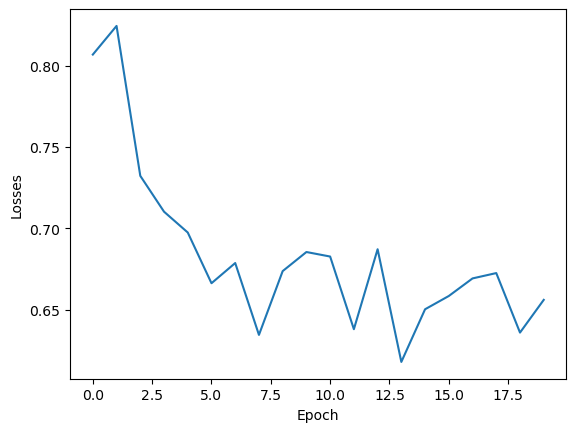

In [124]:
### Plot loss curve using Matplotlib
x = np.arange(0, len(losses), 1)
y = losses

plt.plot(x, y)
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.show()

> **Q6.1)  How do you know when your network is done training?**

Either the model reaches the last epoch specified or if you can see that loss has incremental changes. 



Another way to check if your models (`HNet` and `MyNet`) are well trained is to plot a few image reconstructions to see how well your models do.

In [ ]:
# extract 6 figures from training DataLoader
mini_batch, _ = next(iter(train_loader))
n_examples = min(6, mini_batch.shape[0])
examples = mini_batch[:n_examples]

# compute reconstructions
with torch.no_grad():
    reconstr_examples = model.forward(
        examples.view(n_examples, -1).to(device))

# save image with original v. reconstructed images
comparison = torch.cat([
    examples,
    reconstr_examples.view(-1, 1, 28, 28).cpu()])
save_image(comparison.cpu(), 'training_reconstruction.png', nrow=n_examples)

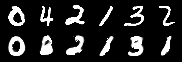

In [126]:
Image('training_reconstruction.png', width=300)

> **Q6.2) What does `torch.no_grad()` do?**

This disables gradient calculations for inference.

### 7. Visualize the learning process

We'll next try to visualize how well the model is learning on the **test set**. To do this, we'll first visualize the "learning process" by viewing reconstruction at various stages.

* Using your checkpoints saved during training, plot a batch of images from the test set and their corresponding reconstructions based on each of your saved models over time. You should see the quality of the reconstructions improving over time.
* To visualize images, you can use the helper functions provided below.


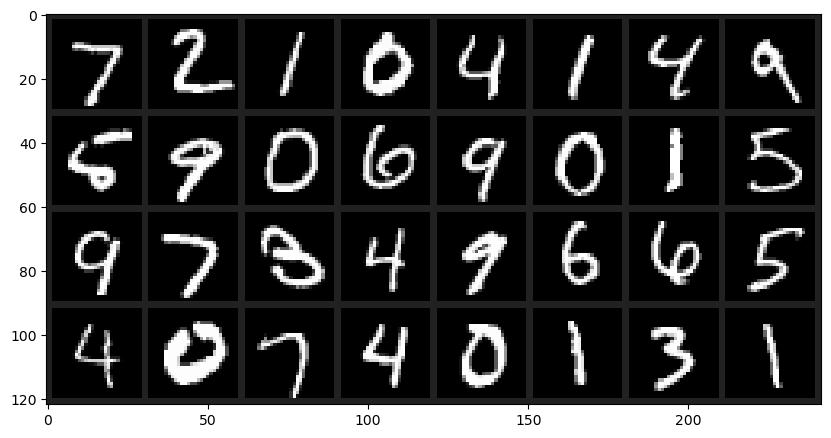

In [119]:
### Helper Functions for Plotting Multiple Images

def imshow(inp,
           figsize=(10,10),
           mean=0.1307, # for MNIST train
           std=0.3081, # for MNIST train
           title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().detach()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def reconstructions_from_batch(model, batch):
    batch = batch.view(-1, 28 * 28).to(device)
    reconstruction = model(batch)
    return reconstruction.reshape(batch.shape[0],1,28,28)

# Get a batch of training data
batch, classes = next(iter(test_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(batch)
imshow(out)

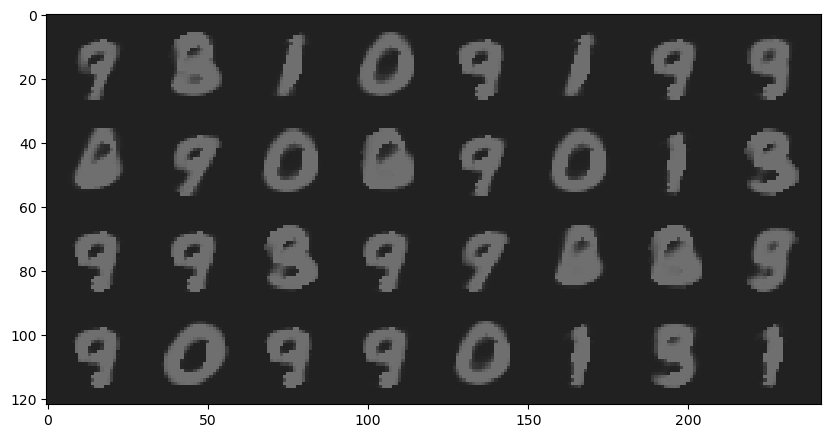

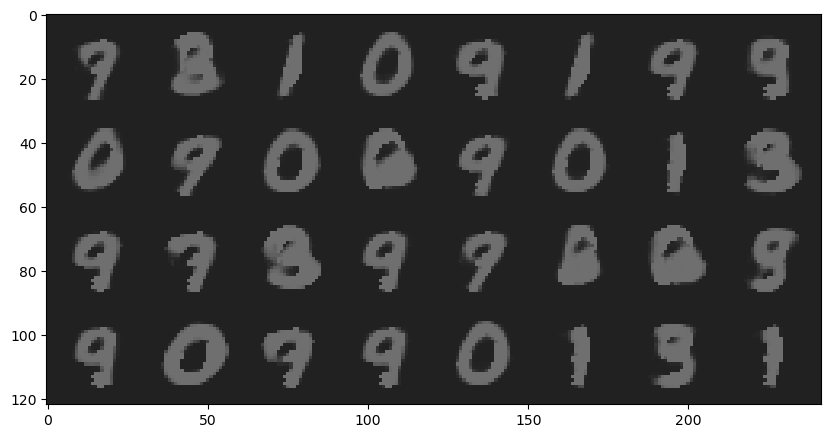

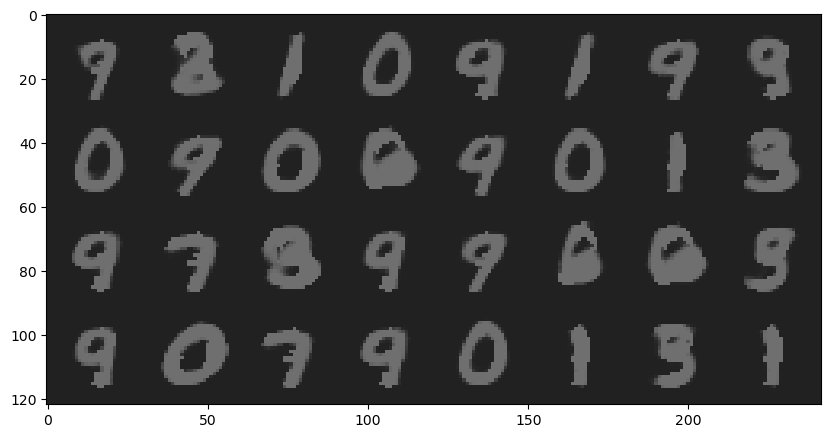

In [127]:
import os 
### Iterate over checkpoints and plot reconstruction
folder = 'autoencoder_checkpoints'
for file in os.listdir(folder):
    f = os.path.join('autoencoder_checkpoints', file)
    model = HNet()
    model.load_state_dict(torch.load(f, weights_only=True))
    model.eval()
    
    batch, classes = next(iter(test_loader))
    reconstructions = reconstructions_from_batch(model, batch)
    
    out = torchvision.utils.make_grid(reconstructions)
### figures from the test set.
    imshow(out)

### 8. Visualize the latent space

As discussed in class, the first half of an autoencoder (the *encoder*) maps the original input into a lower-dimensional latent space.
* Just as shown in Hinton and Salakhutdinov, run your test set of 10,000 MNIST digits through the **encoding layer** of one of the trained networks above. Each sample should readily map to a 2-dimension point. To do this, it will be helpful to fill out a new function, **encode** below, that takes in your trained model and the `test_dataloader` to produce 2d latent embeddings and their corresponding labels.
* Plot each point in these two dimensions, and color each point in this **latent space** by their known **labels**.


In [ ]:
### Write a helper function to grab examples from the test_loader to generate
### pairs of embeddings and their associated labels
def latent(test_loader):
  
 
  

  
    
  
  return embedding, label

def encode(model, device, test_loader):
  #### Fill this in! ####
  latent_embeddings # get the latent embeddings, which will ultimately be a vector of x, y coordinates
  labels # this should match the dim of latent_embeddings, so each pair of coordinates has an associated label
  return latent_embeddings, labels


### Plot latent space representation color-coded
### according to their "true" labels



NameError: name 'test_dataloader' is not defined

> **Q8.1) Does your autoencoder separate out different classes effectively? What classes seem to be closer and what classes are farther apart in this latent space?**

...

## Optional (advanced): Train an autoencoder on CelebA Faces

Real-world images tend to be far more complex than digits from MNIST. As an optional exercise for your own interest, or for students looking for more experience, we'll investigate a subset of CelebA below.

We provide the images in a .zip file (`faces.zip`) in the class's Google Drive folder, which contains a "train" and "test" set of 80k and 10k images, respectively. Although these are color, RGB images, below we've set up the datasets to convert these to grayscale with precomputed means (0.4401) and stds (0.2407), for convenience and easier compute.

In [122]:
### Download faces.zip and unzip it into bmi219_downloads/

In [123]:
preprocessing = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.4401,), (0.2407,)),
])

train_dataset = datasets.ImageFolder(
    'bmi219_downloads/Faces/train',
    transform=preprocessing)

test_dataset = datasets.ImageFolder(
    'bmi219_downloads/Faces/test',
    transform=preprocessing)

FileNotFoundError: [Errno 2] No such file or directory: 'bmi219_downloads/Faces/train'

As above, you'll want to:

1. set up your dataloaders and visualize some of the images
2. set up your autoencoder network architecture
3. define your training criterion and optimizer
4. train your network
    
In this case, you should be able to reuse much of your code from above. Consider a few questions:

1. How well do complex images like faces work with a latent dimension of 2?
2. Do reconstructions look better with a larger bottleneck?
3. What kind of features are poorly reconstructed? What happens to sunglasses, hats, and hands?
4. Try sampling the 2-d latent space close to existing examples (by adding some noise...) or randomly. What do the generated images look like?